In [ ]:
#| default_exp models.bitcn

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BiTCN

Bidirectional Temporal Convolutional Network (BiTCN) is a forecasting architecture based on two temporal convolutional networks (TCNs). The first network ('forward') encodes future covariates of the time series, whereas the second network ('backward') encodes past observations and covariates. This method allows to preserve the temporal information of sequence data, and is computationally more efficient than common RNN methods (LSTM, GRU, ...). As compared to Transformer-based methods, BiTCN has a lower space complexity, i.e. it requires orders of magnitude less parameters.

This model may be a good choice if you seek a small model (small amount of trainable parameters) with few hyperparameters to tune (only 2).

**References**<br>
-[Olivier Sprangers, Sebastian Schelter, Maarten de Rijke (2023). Parameter-Efficient Deep Probabilistic Forecasting. International Journal of Forecasting 39, no. 1 (1 January 2023): 332–45. URL: https://doi.org/10.1016/j.ijforecast.2021.11.011.](https://doi.org/10.1016/j.ijforecast.2021.11.011)<br>
-[Shaojie Bai, Zico Kolter, Vladlen Koltun. (2018). An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling. Computing Research Repository, abs/1803.01271. URL: https://arxiv.org/abs/1803.01271.](https://arxiv.org/abs/1803.01271)<br>
-[van den Oord, A., Dieleman, S., Zen, H., Simonyan, K., Vinyals, O., Graves, A., Kalchbrenner, N., Senior, A. W., & Kavukcuoglu, K. (2016). Wavenet: A generative model for raw audio. Computing Research Repository, abs/1609.03499. URL: http://arxiv.org/abs/1609.03499. arXiv:1609.03499.](https://arxiv.org/abs/1609.03499)<br>

![Figure 1. Visualization of a stack of dilated causal convolutional layers.](imgs_models/bitcn.png)

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| export
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

## 1. Auxiliary Functions

In [ ]:
#| export
class CustomConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, dilation=1, mode='backward', groups=1):
        super().__init__()
        k = np.sqrt(1 / (in_channels * kernel_size))
        weight_data = -k + 2 * k * torch.rand((out_channels, in_channels // groups, kernel_size))
        bias_data = -k + 2 * k * torch.rand((out_channels))
        self.weight = nn.Parameter(weight_data, requires_grad=True)
        self.bias = nn.Parameter(bias_data, requires_grad=True)  
        self.dilation = dilation
        self.groups = groups
        if mode == 'backward':
            self.padding_left = padding
            self.padding_right= 0
        elif mode == 'forward':
            self.padding_left = 0
            self.padding_right= padding            

    def forward(self, x):
        xp = F.pad(x, (self.padding_left, self.padding_right))
        return F.conv1d(xp, self.weight, self.bias, dilation=self.dilation, groups=self.groups)

class TCNCell(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation, mode, groups, dropout):
        super().__init__()
        self.conv1 = CustomConv1d(in_channels, out_channels, kernel_size, padding, dilation, mode, groups)
        self.conv2 = CustomConv1d(out_channels, in_channels * 2, 1)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x):
        h_prev, out_prev = x
        h = self.drop(F.gelu(self.conv1(h_prev)))
        h_next, out_next = self.conv2(h).chunk(2, 1)
        return (h_prev + h_next, out_prev + out_next)

## 2. BiTCN

In [ ]:
#| export
class BiTCN(BaseWindows):
    """ BiTCN

    Bidirectional Temporal Convolutional Network (BiTCN) is a forecasting architecture based on two temporal convolutional networks (TCNs). The first network ('forward') encodes future covariates of the time series, whereas the second network ('backward') encodes past observations and covariates. This is a univariate model.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `hidden_size`: int=16, units for the TCN's hidden state size.<br>
    `dropout`: float=0.1, dropout rate used for the dropout layers throughout the architecture.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    
    def __init__(self,
                 h: int,
                 input_size: int,
                 hidden_size: int = 16,
                 dropout: float = 0.5,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 **trainer_kwargs):
        super(BiTCN, self).__init__(
            h=h,
            input_size=input_size,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            **trainer_kwargs
        )

        #----------------------------------- Parse dimensions -----------------------------------#
        # TCN
        kernel_size = 2  # Not really necessary as parameter, so simplifying the architecture here.
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.h = h
        self.input_size = input_size
        self.dropout = dropout
        
        # Calculate required number of TCN layers based on the required receptive field of the TCN
        self.n_layers_bwd = int(np.ceil(np.log2(((self.input_size - 1) / (self.kernel_size - 1)) + 1)))

        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)        
       
        #---------------------------------- Instantiate Model -----------------------------------#
        
        # Dense layers
        self.lin_hist = nn.Linear(1 + self.hist_exog_size + self.stat_exog_size + self.futr_exog_size, hidden_size)
        self.drop_hist = nn.Dropout(dropout)
        
        # TCN looking back
        layers_bwd = [TCNCell(
                        hidden_size, 
                        hidden_size, 
                        kernel_size, 
                        padding = (kernel_size-1)*2**i, 
                        dilation = 2**i, 
                        mode = 'backward', 
                        groups = 1, 
                        dropout = dropout) for i in range(self.n_layers_bwd)]      
        self.net_bwd = nn.Sequential(*layers_bwd)
        
        # TCN looking forward when future covariates exist
        output_lin_dim_multiplier = 1
        if self.futr_exog_size > 0:
            self.n_layers_fwd = int(np.ceil(np.log2(((self.h + self.input_size - 1) / (self.kernel_size - 1)) + 1)))
            self.lin_futr = nn.Linear(self.futr_exog_size, hidden_size)
            self.drop_futr = nn.Dropout(dropout)
            layers_fwd = [TCNCell(
                            hidden_size, 
                            hidden_size, 
                            kernel_size, 
                            padding = (kernel_size - 1)*2**i, 
                            dilation = 2**i, 
                            mode = 'forward', 
                            groups = 1, 
                            dropout = dropout) for i in range(self.n_layers_fwd)]             
            self.net_fwd = nn.Sequential(*layers_fwd)
            output_lin_dim_multiplier += 2

        # Dense temporal and output layers
        self.drop_temporal = nn.Dropout(dropout)
        self.temporal_lin1 = nn.Linear(self.input_size, hidden_size)
        self.temporal_lin2 = nn.Linear(hidden_size, self.h)
        self.output_lin = nn.Linear(output_lin_dim_multiplier * hidden_size, self.loss.outputsize_multiplier)

    def forward(self, windows_batch):
        # Parse windows_batch
        x             = windows_batch['insample_y'].unsqueeze(-1)       #   [B, L, 1]
        hist_exog     = windows_batch['hist_exog']                      #   [B, L, X]
        futr_exog     = windows_batch['futr_exog']                      #   [B, L + h, F]
        stat_exog     = windows_batch['stat_exog']                      #   [B, S]

        # Concatenate x with historic exogenous
        batch_size, seq_len = x.shape[:2]                               #   B = batch_size, L = seq_len
        if self.hist_exog_size > 0:
            x = torch.cat((x, hist_exog), dim=2)                        #   [B, L, 1] + [B, L, X] -> [B, L, 1 + X]

        # Concatenate x with static exogenous
        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1)    #   [B, S] -> [B, L, S]
            x = torch.cat((x, stat_exog), dim=2)                        #   [B, L, 1 + X] + [B, L, S] -> [B, L, 1 + X + S]

        # Concatenate x with future exogenous & apply forward TCN to x_futr
        if self.futr_exog_size > 0:
            x = torch.cat((x, futr_exog[:, :seq_len]), dim=2)           #   [B, L, 1 + X + S] + [B, L, F] -> [B, L, 1 + X + S + F]
            x_futr = self.drop_futr(self.lin_futr(futr_exog))           #   [B, L + h, F] -> [B, L + h, hidden_size]
            x_futr = x_futr.permute(0, 2, 1)                            #   [B, L + h, hidden_size] -> [B, hidden_size, L + h]
            _, x_futr = self.net_fwd((x_futr, 0))                       #   [B, hidden_size, L + h] -> [B, hidden_size, L + h]
            x_futr_L = x_futr[:, :, :seq_len]                           #   [B, hidden_size, L + h] -> [B, hidden_size, L]
            x_futr_h = x_futr[:, :, seq_len:]                           #   [B, hidden_size, L + h] -> [B, hidden_size, h]

        # Apply backward TCN to x
        x = self.drop_hist(self.lin_hist(x))                            #   [B, L, 1 + X + S + F] -> [B, L, hidden_size]
        x = x.permute(0, 2, 1)                                          #   [B, L, hidden_size] -> [B, hidden_size, L]
        _, x = self.net_bwd((x, 0))                                     #   [B, hidden_size, L] -> [B, hidden_size, L]

        # Concatenate with future exogenous for seq_len
        if self.futr_exog_size > 0:
            x = torch.cat((x, x_futr_L), dim=1)                         #   [B, hidden_size, L] + [B, hidden_size, L] -> [B, 2 * hidden_size, L]

        # Temporal dense layer to go to output horizon
        x = self.drop_temporal(F.gelu(self.temporal_lin1(x)))           #   [B, 2 * hidden_size, L] -> [B, 2 * hidden_size, hidden_size]
        x = self.temporal_lin2(x)                                       #   [B, 2 * hidden_size, hidden_size] -> [B, 2 * hidden_size, h]
        
        # Concatenate with future exogenous for horizon
        if self.futr_exog_size > 0:
            x = torch.cat((x, x_futr_h), dim=1)                         #   [B, 2 * hidden_size, h] + [B, hidden_size, h] -> [B, 3 * hidden_size, h]

        # Output layer to create forecasts
        x = x.permute(0, 2, 1)                                          #   [B, 3 * hidden_size, h] -> [B, h, 3 * hidden_size]
        x = self.output_lin(x)                                          #   [B, h, 3 * hidden_size] -> [B, h, n_outputs] 

        # Map to output domain
        forecast = self.loss.domain_map(x)
        
        return forecast

In [ ]:
show_doc(BiTCN)

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/bitcn.py#L79){target="_blank" style="float:right; font-size:smaller"}

### BiTCN

>      BiTCN (h:int, input_size:int, hidden_size:int=16, dropout:float=0.1,
>             futr_exog_list=None, hist_exog_list=None, stat_exog_list=None,
>             exclude_insample_y=False, loss=MAE(), valid_loss=None,
>             max_steps:int=1000, learning_rate:float=0.001,
>             num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>             val_check_steps:int=100, batch_size:int=32,
>             valid_batch_size:Optional[int]=None, windows_batch_size=1024,
>             inference_windows_batch_size=-1, start_padding_enabled=False,
>             step_size:int=1, scaler_type:str='identity', random_seed:int=1,
>             num_workers_loader:int=0, drop_last_loader:bool=False,
>             optimizer=None, optimizer_kwargs=None, **trainer_kwargs)

BiTCN

Bidirectional Temporal Convolutional Network (BiTCN) is a forecasting architecture based on two temporal convolutional networks (TCNs). The first network ('forward') encodes future covariates of the time series, whereas the second network ('backward') encodes past observations and covariates. This is a univariate model.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`hidden_size`: int=16, units for the TCN's hidden state size.<br>
`dropout`: float=0.1, dropout rate used for the dropout layers throughout the architecture.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

In [ ]:
show_doc(BiTCN.fit, name='BiTCN.fit')

---

### BiTCN.fit

>      BiTCN.fit (dataset, val_size=0, test_size=0, random_seed=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(BiTCN.predict, name='BiTCN.predict')

---

### BiTCN.predict

>      BiTCN.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                     **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | padder_train  | ConstantPad1d | 0     
1 | loss          | MAE           | 0     
2 | scaler        | TemporalNorm  | 0     
3 | lin_hist      | Linear        | 32    
4 | drop_hist     | Dropout       | 0     
5 | net_bwd       | Sequential    | 5.4 K 
6 | drop_temporal | Dropout       | 0     
7 | temporal_lin1 | Linear        | 400   
8 | temporal_lin2 | Linear        | 204   
9 | output_lin    | Linear   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ospra\AppData\Local\Temp\ipykernel_24996\2950578132.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test_df['BiTCN'] = y_hat
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='ds'>

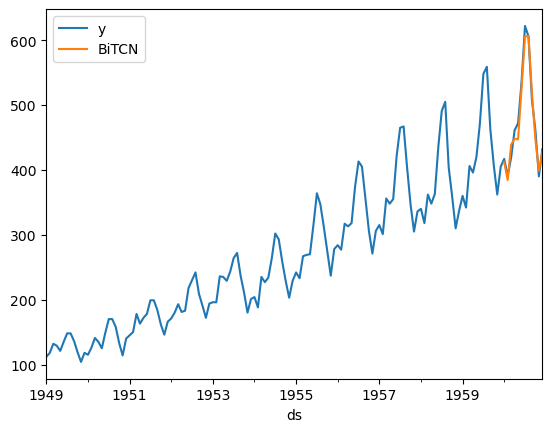

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset

In [ ]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
model = BiTCN(h=12, input_size=24, max_steps=500, scaler_type='standard')
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)
Y_test_df['BiTCN'] = y_hat

#test we recover the same forecast
y_hat2 = model.predict(dataset=dataset)
test_eq(y_hat, y_hat2)

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params
-------------------------------------------------
0  | padder_train  | ConstantPad1d | 0     
1  | loss          | GMM           | 5     
2  | scaler        | TemporalNorm  | 0     
3  | lin_hist      | Linear        | 64    
4  | drop_hist     | Dropout       | 0     
5  | net_bwd       | Sequential    | 5.4 K 
6  | lin_futr      | Linear        | 32    
7  | drop_futr     | Dropout       | 0     
8  | net_fwd       | Sequential    | 6.4 K 
9  | drop_temporal

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:352: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:404: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\tsdataset.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\tsdataset.py:95: UserWarning: To copy construct f

Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\core.py:179: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


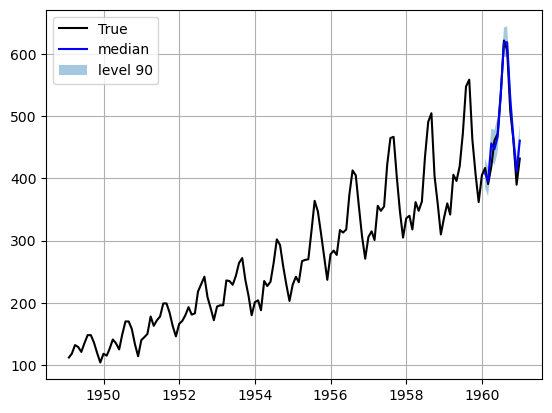

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import GMM, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

In [ ]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[
            BiTCN(h=12,
                input_size=24,
                loss=GMM(n_components=7, return_params=True, level=[80,90]),
                max_steps=500,
                scaler_type='standard',
                futr_exog_list=['y_[lag12]'],
                hist_exog_list=None,
                stat_exog_list=['airline1'],
                ),     
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['BiTCN-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['BiTCN-lo-90'][-12:].values,
                 y2=plot_df['BiTCN-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()